In [0]:
!wget --no-cache https://amubox.univ-amu.fr/s/87i94tZir4FLgTZ/download
!mv download download.zip
!unzip download.zip
!rm download.zip
!unrar x -idk ADNI/AD.rar ADNI/ > /dev/null
!rm ADNI/AD.rar
!unrar x -idk ADNI/NC.rar ADNI/ > /dev/null
!rm ADNI/NC.rar
!unrar x -idk ADNI/pMCI.rar ADNI/ > /dev/null
!rm ADNI/pMCI.rar
!unrar x -idk ADNI/sMCI.rar ADNI/ > /dev/null
!rm ADNI/sMCI.rar

--2020-03-04 12:17:25--  https://amubox.univ-amu.fr/s/87i94tZir4FLgTZ/download
Resolving amubox.univ-amu.fr (amubox.univ-amu.fr)... 139.124.245.127
Connecting to amubox.univ-amu.fr (amubox.univ-amu.fr)|139.124.245.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘download’

download                [<=>                 ]   2.47G  9.59MB/s    in 7m 27s  

2020-03-04 12:24:59 (5.66 MB/s) - ‘download’ saved [2655313503]

Archive:  download.zip
   creating: ADNI/
 extracting: ADNI/AD.rar             
 extracting: ADNI/NC.rar             
 extracting: ADNI/pMCI.rar           
 extracting: ADNI/sMCI.rar           


swADNI_021_S_4558_PT_Coreg,_Avg,_Standardized_Image_and_Voxel_Size_Br_20120409165735384_67_S145251_I296503.nii
Image shape: (91, 109, 91)


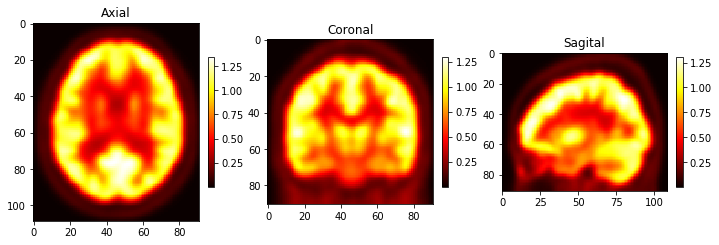

In [0]:
from os.path import join
from os import listdir
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

# load an image
dir_path = join('ADNI', 'NC')
imgs = list(listdir(dir_path))
file_name = imgs[np.random.randint(len(imgs))]
IMAGE_LOCATION = join(dir_path, file_name)

# open the image
IMG = nib.load(IMAGE_LOCATION)

# get the matrix of voxels
FDATA = IMG.get_fdata()
# create axial, sagital coronal arrays
IMG_SIZE = IMG.shape
print(file_name)
print('Image shape: {:s}'.format(str(IMG_SIZE)))
FIX_D1 = int(IMG_SIZE[0]/3)
FIX_D2 = int(IMG_SIZE[1]/2)
FIX_D3 = int(IMG_SIZE[2]/2)

AXIAL = FDATA[:, :, FIX_D3]
CORONAL = FDATA[:, FIX_D2, :]
SAGITAL = FDATA[FIX_D1, :, :]

# display axial, sagital coronal views
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(np.flip(np.transpose(np.flip(AXIAL, 1)), 1), cmap='hot')
plt.title('Axial')
plt.colorbar(fraction=0.036)

plt.subplot(132)
plt.imshow(np.flip(np.transpose(np.flip(CORONAL, 1)), 1), cmap='hot')
plt.title('Coronal')
plt.colorbar(fraction=0.036)

plt.subplot(133)
plt.imshow(np.flip(np.transpose(np.flip(SAGITAL, 1)), 1), cmap='hot')
plt.title('Sagital')
plt.colorbar(fraction=0.036)
plt.tight_layout()

plt.show()

In [0]:
from os import listdir
from os.path import join
from csv import DictReader
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os

pct_val = .2
# classes = ['AD', 'NC', 'sMCI', 'pMCI']
classes = ['AD', 'NC']
cfg = dict()
for ds in classes:
  cfg[ds] = list(listdir(join('ADNI', ds)))
  perm = np.random.permutation(len(cfg[ds]))
  sep = int(np.ceil(len(cfg[ds]) * pct_val))
  cfg['%s_va' % ds] = perm[:sep]
  cfg['%s_tr' % ds] = perm[sep:]


def data_generator(cfg, ds, batch):
  nbc = len(classes)
  db, dby, pos_b = np.zeros((batch, 91, 109, 91, 1)), np.zeros((batch, nbc)), 0
  cl, pos_cl = 0, list()
  pos_cl = [cfg['%s_%s' % (cl, ds)].shape[0] for cl in classes]
  perm_cl = [None for cl in classes]
  while True:
    d = cfg['%s_%s' % (classes[cl], ds)]
    if pos_cl[cl] == d.shape[0]:
      pos_cl[cl] = 0
      perm_cl[cl] = np.random.permutation(d.shape[0])
    fn = join('ADNI', classes[cl], cfg[classes[cl]][d[perm_cl[cl][pos_cl[cl]]]])
    pos_cl[cl] += 1

    img = np.expand_dims(nib.load(fn).get_fdata(), -1)
    db[pos_b], dby[pos_b, cl] = img, 1
    cl = (cl + 1) % nbc
    pos_b += 1
    if pos_b == batch:
      yield db, dby
      pos_b, dby = 0, np.zeros((batch, nbc))


def train_model(cfg, epoch=10, lr=1e-3, batch=2):
  """ Create, compile and train a model
  # Arguments
    :param cfg: dict, generator parameters
    :param epoch: int, epoch
    :param lr: float, learning rate
    :param batch: int, batch (train & valid)
   # Returns
    :return: trained model
  """
  g_tr = data_generator(cfg, 'tr', batch)
  g_va = data_generator(cfg, 'va', batch)
  s_tr = np.sum(np.array([cfg['%s_tr' % cl].shape[0] for cl in classes]))
  s_tr = int(np.ceil(s_tr / batch))
  s_va = np.sum(np.array([cfg['%s_va' % cl].shape[0] for cl in classes]))
  s_va = int(np.ceil(s_va / batch))

  model = create_model(IMG_SIZE + (1,), len(classes))
  model.summary()

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=True),
      loss=tf.keras.losses.categorical_crossentropy,
      metrics=['categorical_accuracy']
  )

  cb = list()
  cb.append(tf.keras.callbacks.CSVLogger(join('log.csv')))

  model.fit_generator(
      generator=g_tr, steps_per_epoch=s_tr,
      validation_data=g_va, validation_steps=s_va,
      epochs=epoch, verbose=1, callbacks=cb
  )
  return model


def plot_log(filename, show=None):
    """ Plot log of training / validation learning curve
    # Arguments
        :param filename: str, csv log file name
        :param show: None / str, show graph if none or save to 'show' directory
    """
    # Load csv file
    keys, values, idx = [], [], None
    with open(filename, 'r') as f:
        reader = DictReader(f)
        for row in reader:
            if len(keys) == 0:
                for key, value in row.items():
                    keys.append(key)
                    values.append(float(value))
                idx = keys.index('epoch')
                continue
            for _, value in row.items():
                values.append(float(value))
        values = np.reshape(values, newshape=(-1, len(keys)))
        values[:, idx] += 1
    # Plot
    fig = plt.figure(figsize=(4, 6))
    fig.subplots_adjust(top=0.95, bottom=0.05, right=0.95)
    fig.add_subplot(211)
    for i, key in enumerate(keys):
        # training loss
        if key.find('loss') >= 0:   # and not key.find('val') >= 0:
            plt.plot(values[:, idx], values[:, i], label=key)
    plt.legend()
    plt.title('Training loss')
    fig.add_subplot(212)
    for i, key in enumerate(keys):
        # acc
        if key.find('acc') >= 0:
            plt.plot(values[:, idx], values[:, i], label=key)
    plt.legend()
    plt.title('Training and validation accuracy')
    if show is not None:
        fig.savefig(join(show, 'log.png'))
    else:
        plt.show()

In [0]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv3D, MaxPool3D, Dropout, BatchNormalization , Input, GlobalMaxPooling3D, SpatialDropout3D

In [0]:

def create_model(input_shape, nbc):

  model = Sequential()

  model.add(Input(input_shape))

  model.add(Conv3D(filters=16,kernel_size=(3,3,3),activation='relu',use_bias=False))
  model.add(BatchNormalization())
  model.add(SpatialDropout3D(1/16))   #当我们对该张量使用dropout技术时，你会发现普通的dropout会随机独立地将部分元素置零，而SpatialDropout1D会随机地对某个特定的纬度全部置零
  model.add(MaxPool3D(2))


  model.add(Conv3D(filters=24,kernel_size=(3,3,3),activation='relu',use_bias=False))
  model.add(BatchNormalization())
  model.add(SpatialDropout3D(2/24))

  model.add(Conv3D(filters=36,kernel_size=(3,3,3),activation='relu',use_bias=False))
  model.add(BatchNormalization())
  model.add(SpatialDropout3D(3/36))


  model.add(GlobalMaxPooling3D())

  model.add(Dense(nbc,activation='softmax'))

  return model

  # """ Create a keras model
  # # Parameters
  #   :param input_shape: tuple, input shape
  #   :param nbc: int, number of classes
  # # Returns
  #   :return: keras model
  # """
  # pass

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 89, 107, 89, 16)   432       
_________________________________________________________________
batch_normalization_4 (Batch (None, 89, 107, 89, 16)   64        
_________________________________________________________________
spatial_dropout3d_4 (Spatial (None, 89, 107, 89, 16)   0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 44, 53, 44, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 42, 51, 42, 24)    10368     
_________________________________________________________________
batch_normalization_5 (Batch (None, 42, 51, 42, 24)    96        
_________________________________________________________________
spatial_dropout3d_5 (Spatial (None, 42, 51, 42, 24)   

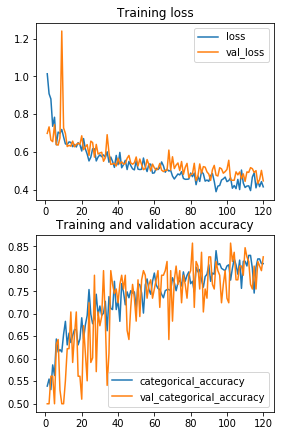

In [0]:
model = train_model(cfg, epoch=120, lr=1e-3, batch=2)
plot_log(join('log.csv'), show=None)

In [0]:
# batch too small, learning curve oscillates